# Lab 1 Task 2

In [56]:
# !pip install thop
# !pip install torchsummary

In [57]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
import argparse
import os
import numpy as np
from torch.utils.data import random_split
from torch.utils.tensorboard import SummaryWriter
from thop import profile
from torchsummary import summary

In [58]:
# Check if CUDA is available
print(torch.cuda.is_available())

True


In [59]:
# Calculate mean and std of dataset
def get_mean_std(dataset, ratio=1):
    # Get mean and std by sample ratio
    dataloader = torch.utils.data.DataLoader(dataset, batch_size=int(len(dataset)*ratio), shuffle=True, num_workers=2)

    data = next(iter(dataloader))[0]     # get the first iteration data
    mean = np.mean(data.numpy(), axis=(0,2,3))
    std = np.std(data.numpy(), axis=(0,2,3))
    return mean, std

train_dataset = torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform=transforms.ToTensor())
test_dataset = torchvision.datasets.CIFAR10(root='./data', train=False, download=True, transform=transforms.ToTensor())

train_mean, train_std = get_mean_std(train_dataset)
test_mean, test_std = train_mean, train_std
print(train_mean, train_std)
print(test_mean, test_std)

Files already downloaded and verified
Files already downloaded and verified
[0.49140182 0.482155   0.4465303 ] [0.24703269 0.24348497 0.26158804]
[0.49140182 0.482155   0.4465303 ] [0.24703269 0.24348497 0.26158804]


In [60]:
##### data augmentation & normalization #####
transform_train = transforms.Compose([
    # 同學實作部分：Add data augmentation here
    # transforms.RandomCrop(32,padding=4),
    # transforms.RandomHorizontalFlip(),
    # transforms.RandomResizedCrop(224),
    # transforms.RandomRotation(10),
    transforms.Resize(256),
    transforms.RandomResizedCrop(224, scale=(0.8, 1.0)),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(), # Transform to tensor
    transforms.Normalize(mean=train_mean, std=train_std), # Normalization
])

transform_test = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize(mean=test_mean, std=test_std),
])

In [ ]:
# Dataset
trainset = torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform=transform_train)
test_ds = torchvision.datasets.CIFAR10(root='./data', train=False, download=True, transform=transform_test)

image, label = trainset[0]
print("image shape: ", image.shape)

# Split validation dataset
torch.manual_seed(43)     # Ensure reproducibility
val_size = 5000       # Take 5000 images as validation set
train_size = len(trainset) - val_size
train_ds, val_ds = random_split(trainset, [train_size, val_size])
print("train length: ", len(train_ds))
print("val length: ", len(val_ds))
print("test length: ", len(test_ds))

# Declare batch size
# 學生實作部分：Set batch size
BATCH_SIZE = 128
trainloader = torch.utils.data.DataLoader(train_ds, batch_size=BATCH_SIZE, shuffle=True, num_workers=2)
valloader = torch.utils.data.DataLoader(val_ds, batch_size=BATCH_SIZE, shuffle=False, num_workers=2)
testloader = torch.utils.data.DataLoader(test_ds, batch_size=BATCH_SIZE, shuffle=False, num_workers=2)

Files already downloaded and verified
Files already downloaded and verified
image shape:  torch.Size([3, 224, 224])
train length:  45000
val length:  5000
test length:  10000


In [62]:
class BasicBlock(nn.Module):
    def __init__(self, in_channels, out_channels, stride=1):
        super(BasicBlock, self).__init__()
        # 學生實作部分：Define the two convolutional layers and the shortcut connection
        self.conv1 = nn.Conv2d(in_channels,out_channels,kernel_size=3,stride=stride,padding=1, bias=False )
        self.bn1 = nn.BatchNorm2d(out_channels)
        self.relu = nn.ReLU(inplace=True)

        self.conv2 = nn.Conv2d(out_channels,out_channels,kernel_size=3,stride=1,padding=1,bias=False)
        self.bn2 = nn.BatchNorm2d(out_channels)
        
        self.downsample = nn.Sequential()


    def forward(self, x):
        # 學生實作部分：Define the forward pass using convolutional layers and the shortcut connection
        identity = x

        if self.downsample is not None:
            identity = self.downsample(x)

        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu(out)

        out = self.conv2(out)
        out = self.bn2(out)

        out += identity
        out = self.relu(out)

        return out

class ResNet18(nn.Module):
    def __init__(self, num_classes=1000):
        super(ResNet18, self).__init__()
        # 學生實作部分：Define the ResNet-18 architecture using BasicBlock
        self.in_channels = 64

        self.conv1   = nn.Conv2d(3, 64, kernel_size=7, stride=2, padding=3, bias=False)
        self.bn1     = nn.BatchNorm2d(64)
        self.relu    = nn.ReLU(inplace=True)
        self.maxpool = nn.MaxPool2d(kernel_size=3, stride=2, padding=1)


        self.layer1 = self._make_layer(BasicBlock, out_channels=64,  num_blocks=2, stride=1)
        self.layer2 = self._make_layer(BasicBlock, out_channels=128, num_blocks=2, stride=2)
        self.layer3 = self._make_layer(BasicBlock, out_channels=256, num_blocks=2, stride=2)
        self.layer4 = self._make_layer(BasicBlock, out_channels=512, num_blocks=2, stride=2)

        # Head
        self.avgpool = nn.AdaptiveAvgPool2d((1, 1)) 
        self.fc      = nn.Linear(512, num_classes)

    def _make_layer(self, block, out_channels, num_blocks, stride):
        # 學生實作部分：Define make_layer function to create layers of blocks
        layers = []
        first_block = block(self.in_channels, out_channels, stride)

        if stride != 1 or self.in_channels != out_channels:
            first_block.downsample = nn.Sequential(
                nn.Conv2d(self.in_channels, out_channels,
                        kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(out_channels)
            )

        layers.append(first_block)
        self.in_channels = out_channels
        for _ in range(1, num_blocks):
            layers.append(block(self.in_channels, out_channels))
        return nn.Sequential(*layers)

    def forward(self, x):
        # 學生實作部分：Define the forward pass of ResNet-18
        # Stem
        out = self.conv1(x)   
        out = self.bn1(out)
        out = self.relu(out)
        out = self.maxpool(out)  

        # Stages
        out = self.layer1(out)   
        out = self.layer2(out)  
        out = self.layer3(out)   
        out = self.layer4(out)   

        # Head
        out = self.avgpool(out) 
        out = torch.flatten(out, 1)  
        out = self.fc(out) 
        return out

In [63]:
# Create SummaryWriter
writer = SummaryWriter("../tensorboard")

model = ResNet18(num_classes=10)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model.to(device)
# Print model summary
summary(model, (3, 224, 224))

# Calculate FLOPs and Params
dummy_input = torch.randn(1, 3, 32, 32).to(device)
flops, params = profile(model, inputs=(dummy_input, ))
print(f"FLOPs: {flops/1e6:.2f} MFLOPs")
print(f"Params: {params/1e6:.2f} M")

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 112, 112]           9,408
       BatchNorm2d-2         [-1, 64, 112, 112]             128
              ReLU-3         [-1, 64, 112, 112]               0
         MaxPool2d-4           [-1, 64, 56, 56]               0
            Conv2d-5           [-1, 64, 56, 56]          36,864
       BatchNorm2d-6           [-1, 64, 56, 56]             128
              ReLU-7           [-1, 64, 56, 56]               0
            Conv2d-8           [-1, 64, 56, 56]          36,864
       BatchNorm2d-9           [-1, 64, 56, 56]             128
             ReLU-10           [-1, 64, 56, 56]               0
       BasicBlock-11           [-1, 64, 56, 56]               0
           Conv2d-12           [-1, 64, 56, 56]          36,864
      BatchNorm2d-13           [-1, 64, 56, 56]             128
             ReLU-14           [-1, 64,

In [ ]:
# Setting parameter
EPOCH = 40
pre_epoch = 0
lr = 0.05

# 同學可以根據自己需求調整optimizer, criterion與lr_scheduler
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=lr, momentum=0.9, weight_decay=5e-4)
# optimizer = optim.Adam(model.parameters(),lr = lr)
scheduler = optim.lr_scheduler.StepLR(optimizer,step_size=20,gamma=0.1)
y = []
best_model_path = 'best_resnet18_5.pth'

# Record training and validation metrics
train_losses = []
train_accuracies = []
val_losses = []
val_accuracies = []
best_val_acc = 0.0

# Training and validation loop
for epoch in range(pre_epoch, EPOCH):
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0

    # 學生實作部分：Complete the training and validation loop
    for inputs, labels in trainloader:
        inputs, labels = inputs.cuda(), labels.cuda()  
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item() * inputs.size(0)
        _, predicted = outputs.max(1)
        total += labels.size(0)
        correct += predicted.eq(labels).sum().item()

    train_loss = running_loss / total
    train_losses.append(train_loss)
    train_acc = 100. * correct / total
    train_accuracies.append(train_acc)
    
    # ========== VALIDATION PHASE ==========
    model.eval()
    val_loss = 0.0
    val_correct = 0
    val_total = 0

    with torch.no_grad():
        for inputs, labels in valloader:
            inputs, labels = inputs.cuda(), labels.cuda()
            outputs = model(inputs)
            loss = criterion(outputs, labels)

            val_loss += loss.item() * inputs.size(0)
            _, predicted = outputs.max(1)
            val_total += labels.size(0)
            val_correct += predicted.eq(labels).sum().item()

    val_loss = val_loss / val_total
    val_losses.append(val_loss)
    val_acc = 100. * val_correct / val_total
    val_accuracies.append(val_acc)
    
    
    # 儲存最佳模型
    if val_acc > best_val_acc:
        best_val_acc = val_acc
        torch.save(model.state_dict(), best_model_path)

    scheduler.step()
    current_lr = optimizer.param_groups[0]['lr']
    print(f"Epoch [{epoch+1}/{EPOCH}] "
          f"Train Loss: {train_loss:.4f} | Train Acc: {train_acc:.2f}% | "
          f"Val Loss: {val_loss:.4f} | Val Acc: {val_acc:.2f}% |"
          f"LR: {current_lr:.6f}"
          )


Epoch [1/40] Train Loss: 1.7051 | Train Acc: 38.10% | Val Loss: 1.4620 | Val Acc: 46.90% |LR: 0.050000
Epoch [2/40] Train Loss: 1.1363 | Train Acc: 58.93% | Val Loss: 1.2090 | Val Acc: 57.92% |LR: 0.050000
Epoch [3/40] Train Loss: 0.8406 | Train Acc: 70.21% | Val Loss: 1.0619 | Val Acc: 63.48% |LR: 0.050000
Epoch [4/40] Train Loss: 0.6832 | Train Acc: 76.07% | Val Loss: 0.6797 | Val Acc: 76.38% |LR: 0.050000
Epoch [5/40] Train Loss: 0.5846 | Train Acc: 79.86% | Val Loss: 0.6333 | Val Acc: 77.92% |LR: 0.050000
Epoch [6/40] Train Loss: 0.5175 | Train Acc: 82.09% | Val Loss: 0.7116 | Val Acc: 75.62% |LR: 0.050000
Epoch [7/40] Train Loss: 0.4666 | Train Acc: 83.80% | Val Loss: 0.5509 | Val Acc: 81.38% |LR: 0.050000
Epoch [8/40] Train Loss: 0.4302 | Train Acc: 84.98% | Val Loss: 0.5683 | Val Acc: 80.44% |LR: 0.050000
Epoch [9/40] Train Loss: 0.4025 | Train Acc: 85.99% | Val Loss: 0.5493 | Val Acc: 81.80% |LR: 0.050000
Epoch [10/40] Train Loss: 0.3646 | Train Acc: 87.20% | Val Loss: 0.5140 |

In [65]:
# Load the best model and evaluate on the test set
model.eval()

test_correct = 0
test_total = 0
with torch.no_grad():
    for test_inputs, test_labels in testloader:
        test_inputs, test_labels = test_inputs.to(device), test_labels.to(device)
        test_outputs = model(test_inputs)
        _, test_predicted = test_outputs.max(1)
        test_total += test_labels.size(0)
        test_correct += test_predicted.eq(test_labels).sum().item()
test_accuracy = 100. * test_correct / test_total
print(f"Best Model Test Accuracy: {test_accuracy:.2f}%")

Best Model Test Accuracy: 92.66%


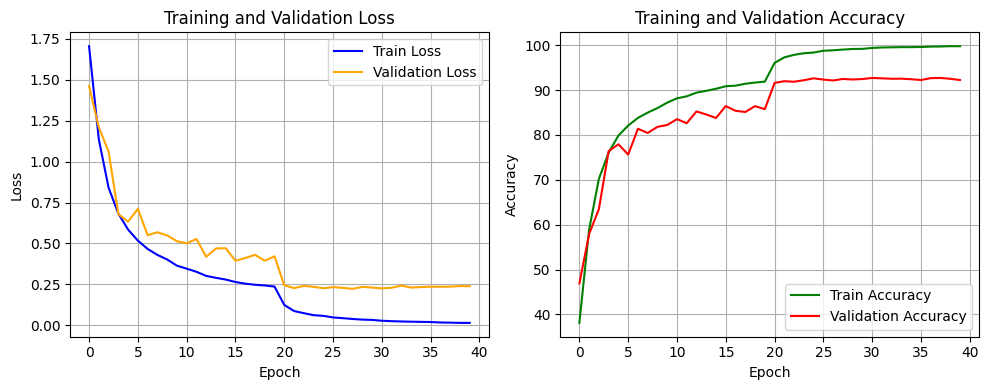

In [66]:
##### Plot loss & accuracy graph #####
import matplotlib.pyplot as plt
# 學生實作部分：Plot training and validation loss and accuracy curves
plt.figure(figsize=(10, 4))
plt.subplot(1, 2, 1)
plt.plot(train_losses, label='Train Loss', color='blue')
plt.plot(val_losses, label='Validation Loss', color='orange')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.grid(True)


plt.subplot(1, 2, 2)
plt.plot(train_accuracies, label='Train Accuracy', color='green')
plt.plot(val_accuracies, label='Validation Accuracy', color='red')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Training and Validation Accuracy')
plt.legend()
plt.grid(True)
 
plt.tight_layout()

plt.show()